VGG16 Transfer Learning Approach
Deep Convolutional Neural networks may take days to train and require lots of computational resources. So to overcome this we will use Transfer Learning for implementing VGG16 with Keras.

Transfer learning is a technique whereby a deep neural network model that was trained earlier on a similar problem is leveraged to create a new model at hand. One or more layers from the already trained model are used in the new model. We will go through more details in a subsequent section below.

Define training and testing path of dataset
It is necessary to put the images of both classes of dog and cat in separate subfolders under train and test folder 


In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Reading sample Images
Let us just read a couple of random images for the data set to see what types of images we have. The use of cv2.imshow is disabled in Colab because it causes Jupyter sessions to crash, so as a substitution, we are using cv2_imshow().

In [19]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout
from keras import backend as K
import keras
from keras.models import Sequential, Model
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import MaxPool2D
from google.colab.patches import cv2_imshow

Preparation of datasets
We generally encountered problems where we try to load a dataset but there is not enough memory in your machine.

Keras provides the ImageDataGenerator class that defines the configuration for image data preparation and augmentation. The generator will progressively load the images in your dataset, allowing you to work with both small and very large datasets containing thousands or millions of images that may not fit into system memory.

In [20]:
train_path="/content/gdrive/MyDrive/Colab Notebooks/Train"
test_path="/content/gdrive/MyDrive/Colab Notebooks/Validation"
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

In [21]:
print(class_names)
print(class_names_test)

['cat', 'dog']
['cat', 'dog']


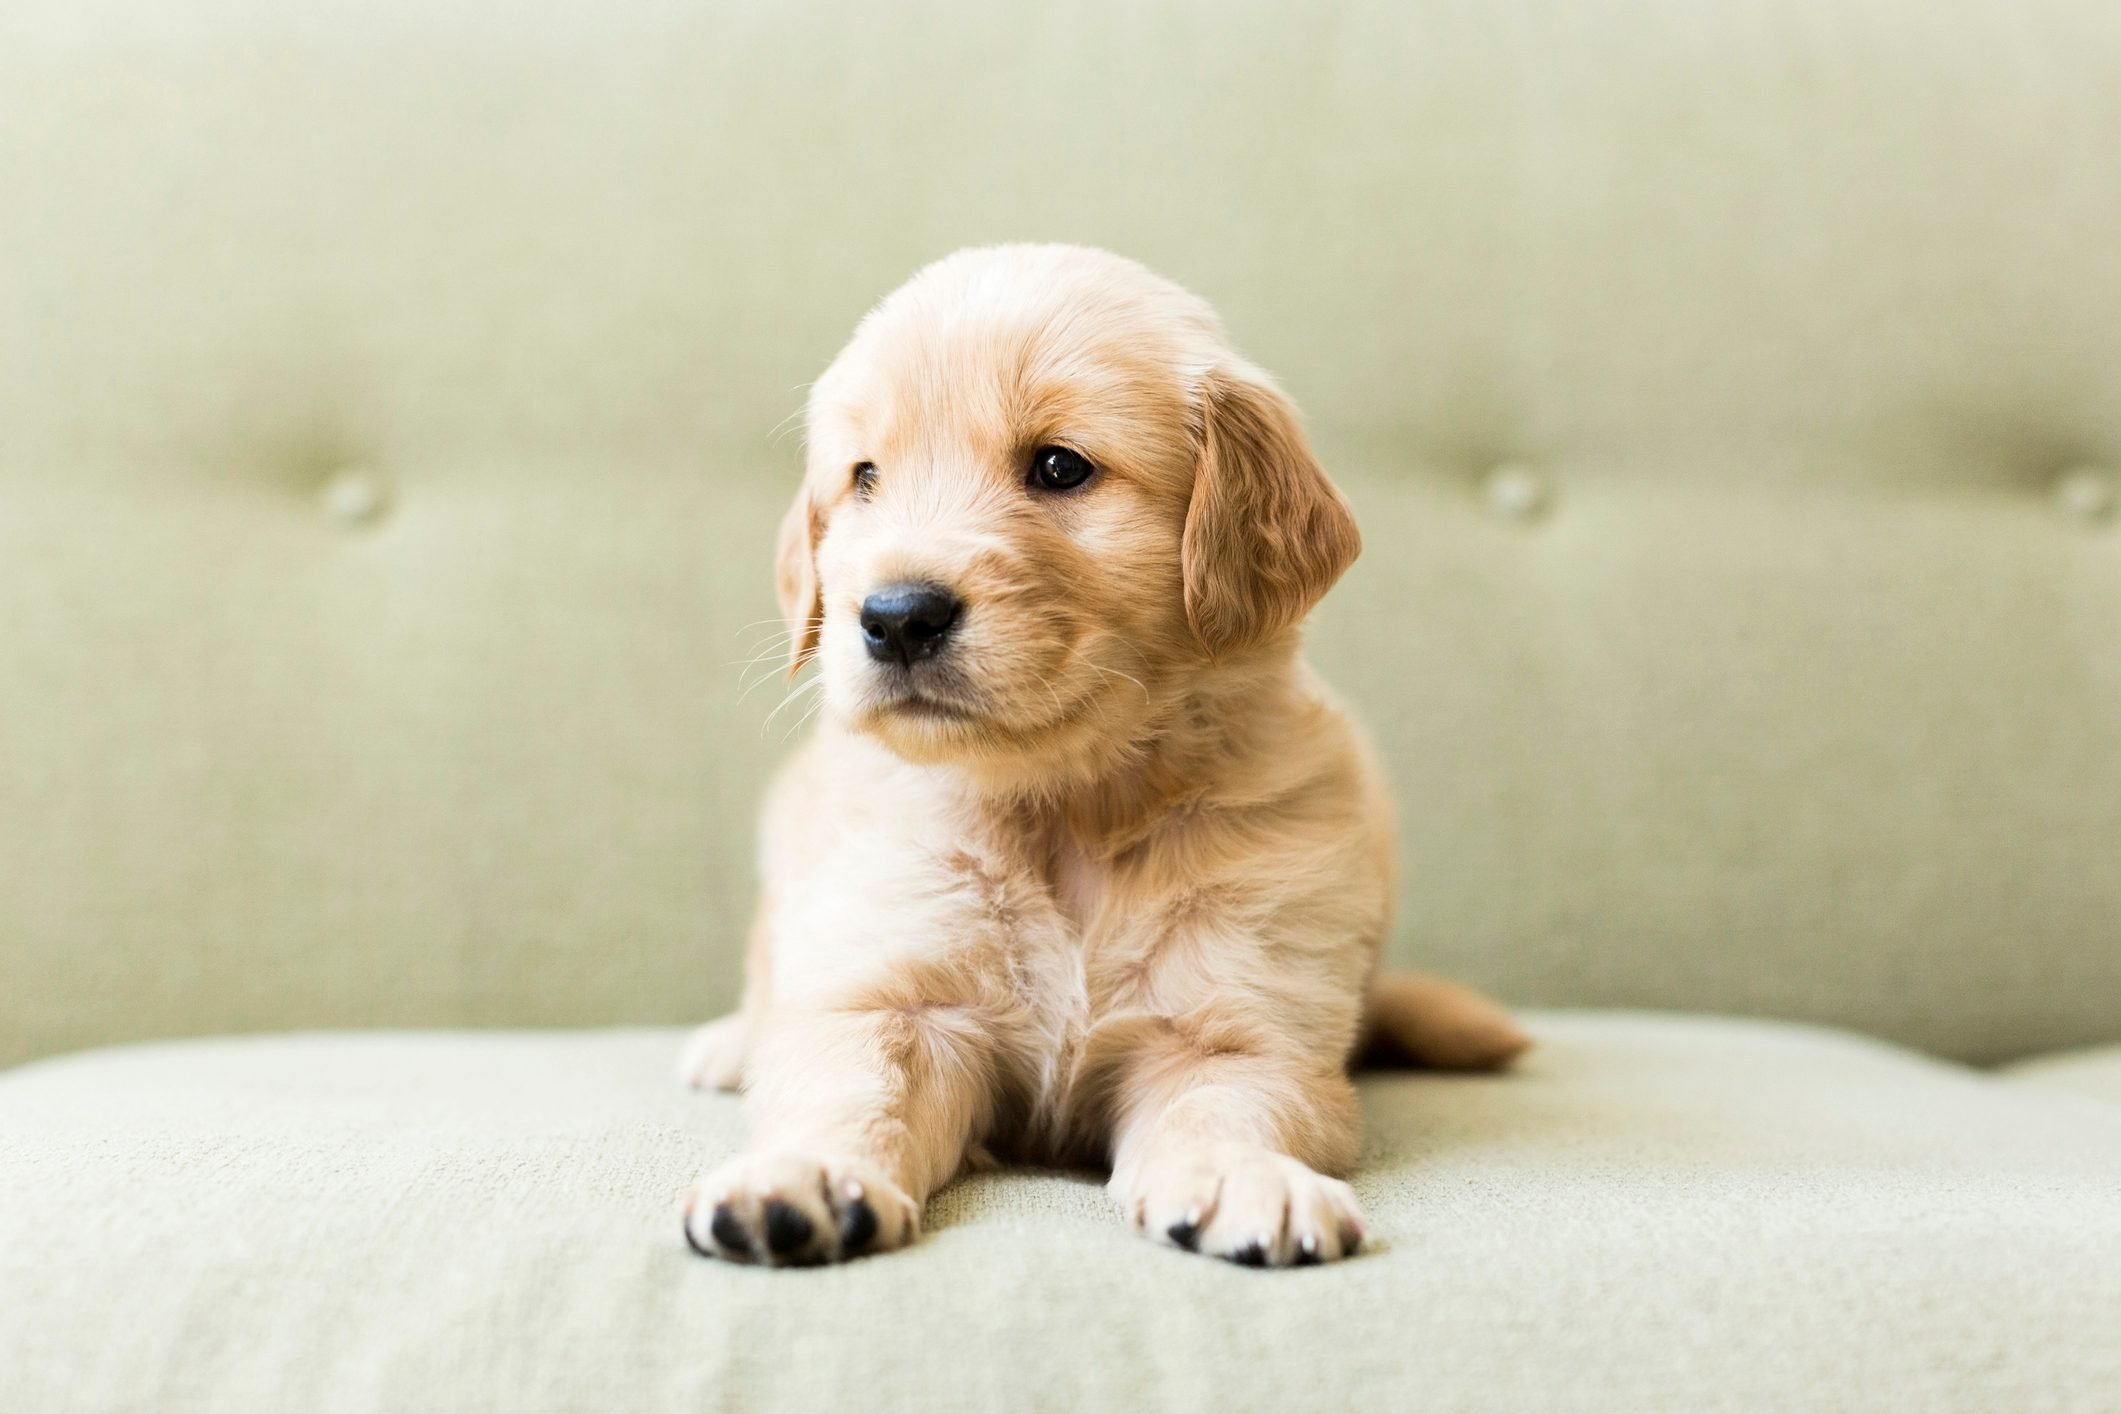

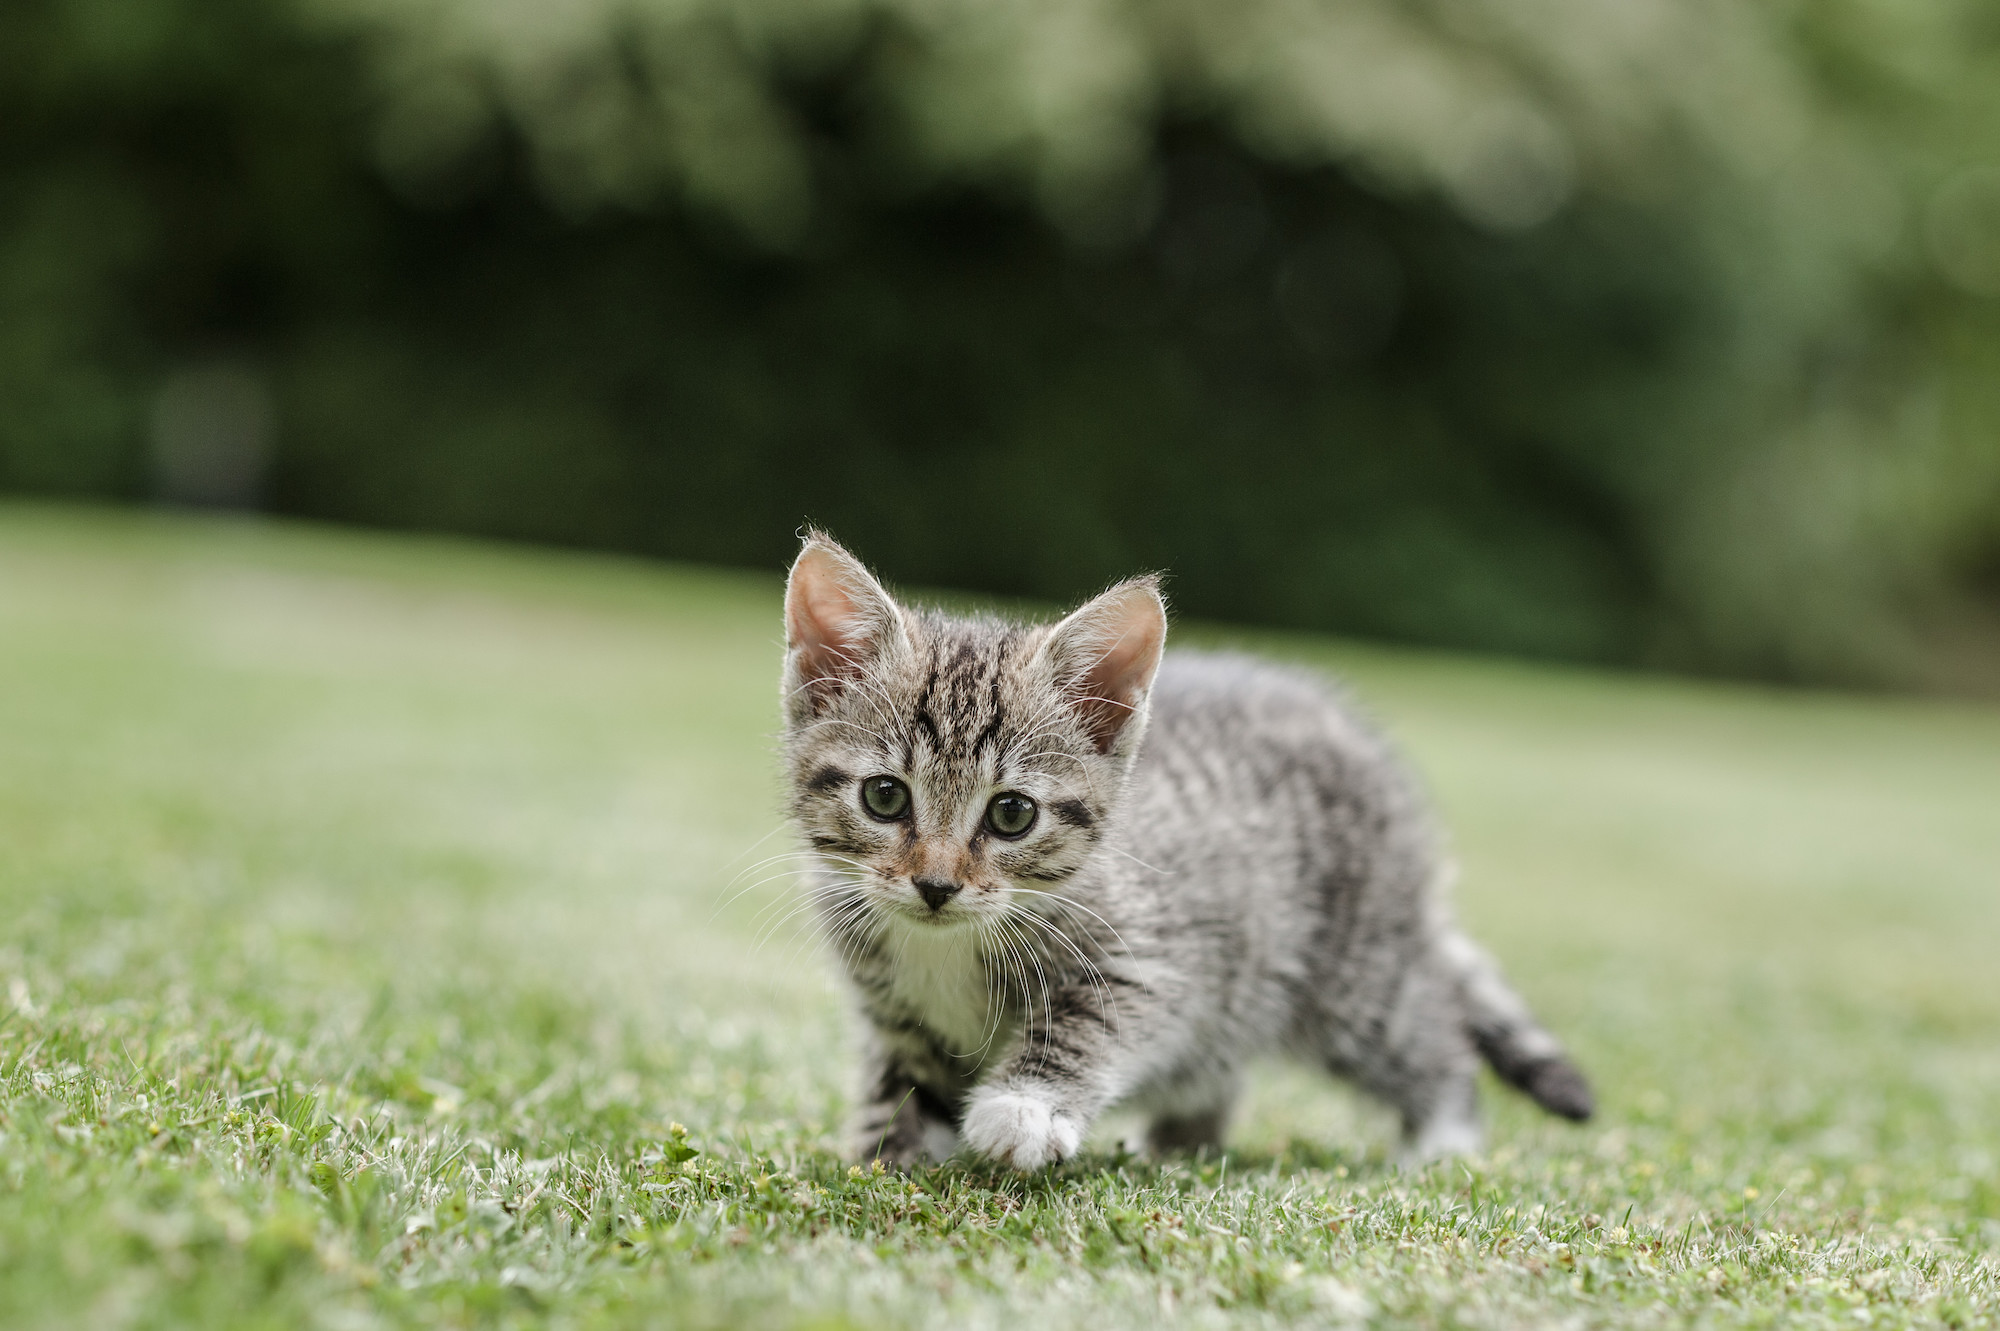

In [22]:
#Sample datasets images
image_dog=cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/Train/dog/dog001.jpg")
cv2_imshow(image_dog)
image_cat=cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/Train/cat/cat001.jpg")
cv2_imshow(image_cat)

In [23]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()

In [24]:
train_generator = train_datagen.flow_from_directory("/content/gdrive/MyDrive/Colab Notebooks/Train",target_size=(224, 224),batch_size=32,shuffle=True,class_mode='binary')
test_generator = test_datagen.flow_from_directory("/content/gdrive/MyDrive/Colab Notebooks/Validation",target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')

Found 4 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


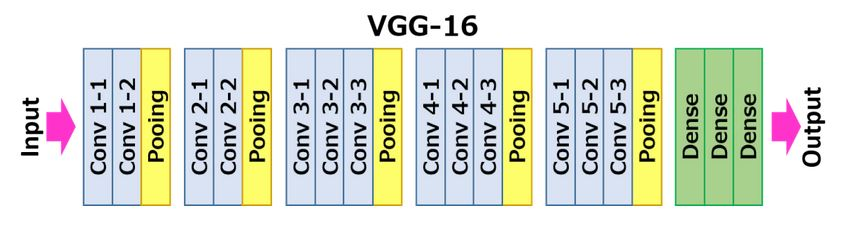

In [25]:
def VGG16():
    model = Sequential()
    model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dense(128, activation='relu', name='fc2'))
    model.add(Dense(1, activation='sigmoid', name='output'))
    return model
    

In [26]:
model=VGG16()

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 256)      

As we discussed in the above section that we will use Transfer Learning for implementing VGG16 with Keras. So we will reuse the model weights from pre-trained models that were developed for standard computer vision benchmark datasets like ImageNet. We have downloaded pre-trained weights that do not have top layers weights. As you see above we have replaced the last three layers by our own layer and pre-trained weights do not contain the weights of newly three dense layers. So that is why we have to download pre-trained layer without top. (Link to download these weights are given at the bottom of the article)
https://drive.google.com/uc?export=download&id=1pjBpzyKE7QmvKZRy5zUFxDXYZQ5F7ow0

Since we only have to initialize the weight to the last convolutional that is why we have called model and pass input as model input and output as the last convolutional block

In [28]:
Vgg16 = Model(inputs=model.input, outputs=model.get_layer('vgg16').output)

Now load the weights using the function load_weights of Keras

In [30]:
Vgg16.load_weights("/content/gdrive/MyDrive/Colab Notebooks/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")

As we know that initial layers learn very general features and as we go higher up the network, the layers tend to learn patterns more specific to the task it is being trained on. So using these properties of the layer we want to keep the initial layers intact (freeze that layer) and retrain the later layers for our task. This is also termed as finetuning of a network.

The advantage of finetuning is that we do not have to train the entire layer from scratch and hence the amount of data required for training is not much either. Also, parameters that need to be updated are less and hence the amount of time required for training will also be less.

In Keras, each layer has a parameter called “trainable”. For freezing the weights of a particular layer, we should set this parameter to False, indicating that this layer should not be trained. After that, we go over each layer and select which layers we want to train.
In our case, we are freezing all the convolutional block of VGG16

In [33]:
for layer in Vgg16.layers:
    layer.trainable = False

In [34]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f32cc418e10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f32cc3aa450> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f32cc34ddd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f32cc4a9050> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f32cc35cbd0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f32cc34b8d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f32cc353d50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f32cc35c550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f32cc370b10> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f32cc371890> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f32cc35df90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x

We then compile the VGG16 using the compile function. This function expects three parameters: the optimizer, the loss function, and the metrics of performance. We are going to use stochastic gradient descent as an optimizer. Also since we are doing binary classification, we use binary_crossentropy as the choice for the loss function.

In [35]:
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

## **Early Stoping**
A basic problem that arises in training a neural network is to decide how many epochs a model should be trained. Too many epochs may lead to overfitting of the model and too few epochs may lead to underfitting of the model.
So to overcome this problem the concept of Early Stoping is used.

In this technique, we can specify an arbitrarily large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset. Keras supports the early stopping of training via a callback called EarlyStopping.

Below are various arguments in EarlyStopping.

monitor – This allows us to specify the performance measure to monitor in order to end training.

mode – It is used to specify whether the objective of the chosen metric is to increase maximize or to minimize.

verbose – To discover the training epoch on which training was stopped, the “verbose” argument can be set to 1. Once stopped, the callback will print the epoch number.

patience – The first sign of no further improvement may not be the best time to stop training. This is because the model may coast into a plateau of no improvement or even get slightly worse before getting much better. We can account for this by adding a delay to the trigger in terms of the number of epochs on which we would like to see no improvement. This can be done by setting the “patience” argument.

In [36]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

**Model Check Point**

The EarlyStopping callback will stop training once triggered, but the model at the end of training may not be the model with the best performance on the validation dataset.

An additional callback is required that will save the best model observed during training for later use. This is known as the ModelCheckpoint callback.

The ModelCheckpoint callback is flexible in the way it can be used, but in this case, we will use it only to save the best model observed during training as defined by a chosen performance measure on the validation dataset.

In [37]:
mc = ModelCheckpoint('/content/gdrive/My Drive/best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [38]:
H = model.fit_generator(train_generator,validation_data=test_generator,epochs=10,verbose=1,callbacks=[mc,es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1/1 [==============================] - 8s 8s/step - loss: 3.9244 - accuracy: 0.7500 - val_loss: 7.5096 - val_accuracy: 0.2500
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 0.6778 - accuracy: 0.7500 - val_loss: 8.4055 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.3680 - accuracy: 0.7500 - val_loss: 7.9916 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.1961 - accuracy: 0.7500 - val_loss: 7.8817 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 5s 5s/step - loss: 3.6576e-04 - accuracy: 1.0000 - val_loss: 7.8801 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 2.5092 - accuracy: 0.7500 - val_loss: 6.1047 - val_accuracy: 0.7500
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: 4.4881e-12 - accuracy: 1.0000 - val_loss: 4.3322 - val_accuracy: 0.7500
Epoch 8/10
1/1 [=================

As we can see here that if we set epochs=100 the model training got a an early stopping as per what we had expected. The weights are saved in a file “best_model.h5“. In the future, we are not required to train the model again we can just load the weight into the model with below command.

In [39]:
model.load_weights("/content/gdrive/My Drive/best_model.h5")

Evaluating the model on test datasets
Let us now evaluate the performance of our model on the unseen testing data set. We can see an accuracy of 75%.

In [40]:
model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.018167074769735336, 1.0]

# **Serialize the Keras Model**
It is the best practice of converting the model into JSON format to save it for the inference program in the future.

In [41]:
model_json = model.to_json()
with open("/content/gdrive/My Drive/model.json","w") as json_file:
  json_file.write(model_json)

# **Dogs Vs Cat Classification Inference Program**
To recap what we have done till now –

We implemented the VGG16 model with Keras.

We saved the best training weights of the model in a file for future use.

We saved the model in JSON format for reusability.

Now it is time to write an inference program that will do the following –

Load the model that we saved in JSON format earlier.

Load the weight that we saved after training the model earlier.

Compile the model.

Load the image that we want to classify.

Perform classification.

In [42]:
from keras.models import model_from_json

In [43]:
def predict_(image_path):
    #Load the Model from Json File
    json_file = open('/content/gdrive/My Drive/model.json', 'r')
    model_json_c = json_file.read()
    json_file.close()
    model_c = model_from_json(model_json_c)
    #Load the weights
    model_c.load_weights("/content/gdrive/My Drive/best_model.h5")
    #Compile the model
    opt = SGD(lr=1e-4, momentum=0.9)
    model_c.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    #load the image you want to classify
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224,224))
    cv2_imshow(image)
    #predict the image
    preds = model_c.predict(np.expand_dims(image, axis=0))[0]
    if preds==0:
        print("Predicted Label:Cat")
    else:
        print("Predicted Label: Dog")

# **Perform Classification**

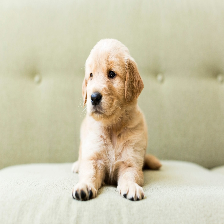

Predicted Label: Dog


In [45]:
predict_("/content/gdrive/MyDrive/Colab Notebooks/Train/dog/dog001.jpg")

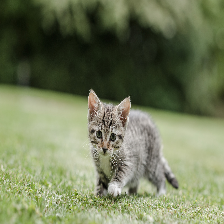

Predicted Label: Dog


In [46]:
predict_("/content/gdrive/MyDrive/Colab Notebooks/Train/cat/cat001.jpg")